In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from scipy import interpolate
image_path = '/Users/patricknaylor/Desktop/Field_Detection/Images/Masked/'
torch.__version__
device = torch.device('mps')



In [31]:

images_paths = list(glob.glob(image_path + '*.jpg'))
scale_percent = 10

images = []
masks = []
for (img) in (images_paths):
    msk = f'{image_path}{img[59:-4]}.npy'
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    images.append(cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA))
    mask = np.load(msk).T
    mask = mask[25: -25, 25: -25]
    x = np.linspace(0, 1, mask.shape[0])
    y = np.linspace(0, 1, mask.shape[1])
    f = interpolate.interp2d(y, x, mask, kind='linear')

    x2 = np.linspace(0, 1, 36)
    y2 = np.linspace(0, 1, 64)

    mask = f(y2, x2)
    mask = np.expand_dims(mask, axis=2)
    
    masks.append(mask)


In [32]:

images_arr = np.stack(images)
masks_arr = np.stack(masks)


In [33]:
images_arr = images_arr.astype(np.uint8)
masks_arr = masks_arr.astype(np.uint8)

In [34]:
class imageDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        mask = self.y[index]
        y = torch.tensor(mask)
        X = self.transform(image)
        return [X, y]

    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()])

    


    

In [35]:
print(np.shape(masks_arr))

(2753, 36, 64, 1)


In [36]:
batch_size = 8
transformed_dataset = imageDataset(X=images_arr, y=masks_arr)
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [2000, 753])
train_dl = DataLoader(train_set, batch_size, shuffle=True)
val_dl = DataLoader(val_set, 1, shuffle=True)


In [37]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5, padding='same')
        self.fc1 = nn.Linear(int(12*72*128*.25), int(4*72*128*.25))
        self.fc2 = nn.Linear(int(4*72*128*.25), int(2*72*128*.25))       
        self.fc3 = nn.Linear(int(2*72*128*.25), int(1*72*128*.25))
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [38]:
def cross_entropy(output, target):
    target = torch.flatten(target, 1)
    loss = -np.sum(target*np.log(output))
    return loss/float(output.shape[0])

model = Model().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [39]:
num_epochs = 10
n_total_steps = len(train_dl)
for epoch in range(num_epochs):
    running_loss = 0.0
    sum = 0
    for i, (input, target) in enumerate(train_dl):
        input = input.to(device)
        target = torch.flatten(target, 1).to(device)

        optimizer.zero_grad()

        outputs = model(input)
        loss = criterion(outputs, target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        sum += 1

        if (i+1) % 20 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



Epoch [1/10], Step [20/250], Loss: 0.6931
Epoch [1/10], Step [40/250], Loss: 0.6930
Epoch [1/10], Step [60/250], Loss: 0.6929
Epoch [1/10], Step [80/250], Loss: 0.6929
Epoch [1/10], Step [100/250], Loss: 0.6927
Epoch [1/10], Step [120/250], Loss: 0.6926
Epoch [1/10], Step [140/250], Loss: 0.6925
Epoch [1/10], Step [160/250], Loss: 0.6924
Epoch [1/10], Step [180/250], Loss: 0.6923
Epoch [1/10], Step [200/250], Loss: 0.6921
Epoch [1/10], Step [220/250], Loss: 0.6919
Epoch [1/10], Step [240/250], Loss: 0.6920
Epoch [2/10], Step [20/250], Loss: 0.6917
Epoch [2/10], Step [40/250], Loss: 0.6917
Epoch [2/10], Step [60/250], Loss: 0.6913
Epoch [2/10], Step [80/250], Loss: 0.6916
Epoch [2/10], Step [100/250], Loss: 0.6911
Epoch [2/10], Step [120/250], Loss: 0.6909
Epoch [2/10], Step [140/250], Loss: 0.6906
Epoch [2/10], Step [160/250], Loss: 0.6904
Epoch [2/10], Step [180/250], Loss: 0.6901
Epoch [2/10], Step [200/250], Loss: 0.6902
Epoch [2/10], Step [220/250], Loss: 0.6893
Epoch [2/10], Step 

torch.Size([36, 64, 1])
torch.Size([36, 64])
torch.Size([36, 64, 1])
torch.Size([36, 64])
torch.Size([36, 64, 1])
torch.Size([36, 64])
torch.Size([36, 64, 1])
torch.Size([36, 64])
torch.Size([36, 64, 1])
torch.Size([36, 64])
torch.Size([36, 64, 1])
torch.Size([36, 64])


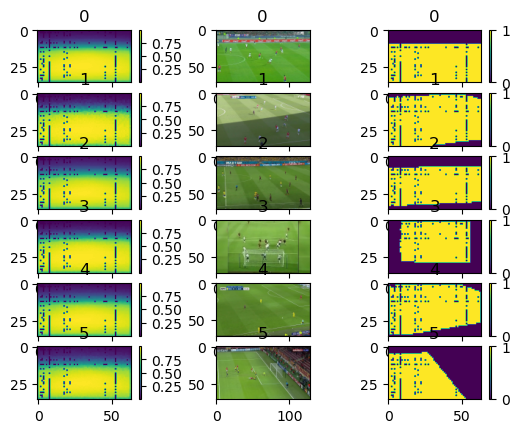

In [40]:
with torch.no_grad():
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        image = images[0,:,:,:]
        mask = labels[0,:,:,:]
        print(mask.size())
        output = model(images).reshape(36, 64)
        plt.subplot(6,3,(idx*3)+1)
        plt.imshow(torch.Tensor.cpu(F.sigmoid(output)))
        plt.colorbar()
        plt.title(idx)
        plt.subplot(6,3,(3*idx)+2)
        plt.imshow(torch.Tensor.cpu(image).permute(1, 2, 0))
        plt.title(idx)
        plt.subplot(6,3,(3*idx)+3)
        plt.imshow(torch.Tensor.cpu(mask))
        plt.colorbar()
        plt.title(idx)
        print(output.size())
        if idx == 5:
            break